In [1]:
# import libraries
import bok_da as bd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

##### 본 매뉴얼은 베이지안 선형회귀모형 추정에 대해 다룬다.

# 베이지안 회귀분석
- 작성자: 고려대학교 경제학과 강규호 교수, 디지털신기술팀 이창훈 과장

## 베이지안 선형회귀모형
### 모형
- $\sigma^{2} \sim IG(\frac{\alpha_{0}}{2}, \frac{\delta_{0}}{2})$
- $\beta \sim Normal(\beta_{0}, B_{0})$
- $Y|\beta, \sigma^{2} \sim Normal(X\beta, \sigma^{2}I_{T})$

### 사전분포에 대한 기본 하이퍼-파라미터
* 샘플링 크기
    * $n$: 깁스-샘플링 크기
    * $n_{0}$: 번인(burn-in) 크기
    * $n_{1}=n-n_{0}$: 사후분포 추론에 사용할 샘플링 크기
* $\beta$ 관련 하이퍼-파라미터 디폴트값
    * $\beta_{0}=0$
    * $B_{0}=25$
* $\sigma^{2}$ 관련 하이퍼-파라미터 디폴트값
    * $\alpha_{0}=5$
    * $\delta_{0}=5$

`bok_da` 라이브러리의 `bayes` 패키지, `linear_model` 모듈의 `gen_hyper_para` 함수를 이용해 선형모형에 대한 하이퍼 파라미터를 설정할 수 있다. 아무런 input을 넣지 않는 경우 디폴트 값으로 설정된다.

In [3]:
from bok_da.bayes.linear_model import gen_hyper_para

In [4]:
hyper = gen_hyper_para()
print(hyper)

{'n': 11000, 'n0': 1000, 'n1': 10000, 'beta0_': 0, 'B0_': 25, 'alpha0': 5, 'delta0': 5, 'sig2': 1.0}


사전분포의 하이퍼-파라미터를 변경하고 싶은 경우, 아래 예시에 따라 조정할 수 있다.

In [5]:
# 예1) sig2 의 하이퍼 파라미터 변경 시
hyper['alpha0'] = 10
hyper['delta0'] = 10
hyper['sig2'] = hyper['alpha0']/hyper['delta0'] # 사전 평균도 다시 계산해야 한다.

# 예2) 깁스-샘플링 크기 변경 시
hyper['n1'] = 20000
hyper['n0'] = int(hyper['n1'] * 0.1) # int 는 오류 방지를 위해 붙일 것을 권장한다.
hyper['n'] = hyper['n0'] + hyper['n1']

print(hyper)

{'n': 22000, 'n0': 2000, 'n1': 20000, 'beta0_': 0, 'B0_': 25, 'alpha0': 10, 'delta0': 10, 'sig2': 1.0}


### 선형회귀모형의 베이지안 추정 예제

* 데이터: 한국 GDP, CPI, M2, 국고채 10년, 미국 10년물 금리

### 1) 자료 불러오기

In [6]:
# 데이터프레임 형태로 데이터 불러오기
df = pd.read_excel("../data/bayes_test_data.xlsx") # test_data 폴더에서 엑셀파일 불러오기
df.columns = ['gdp', 'gdp_l1', 'cpi', 'm2', 'kr10y', 'us10y'] # 데이터 변수 이름 설정하기
df.index = pd.date_range(start='2000-Q4', end='2023-Q4', freq='Q') # 데이터 인덱스(날짜) 설정하기
df

,gdp,gdp_l1,cpi,m2,kr10y,us10y
2000-12-31,-0.324985,2.717335,0.659799,1.417791,7.760,5.12
2001-03-31,1.218106,-0.324985,1.766167,1.752773,6.690,4.93
2001-06-30,1.290518,1.218106,1.157815,2.339417,7.490,5.42
2001-09-30,1.341160,1.290518,0.574675,4.178410,6.440,4.60
2001-12-31,1.747232,1.341160,-0.254330,-0.487594,6.810,5.07
...,...,...,...,...,...,...
2022-09-30,0.233454,0.747667,1.128388,0.938318,3.497,3.83
2022-12-31,-0.303428,0.233454,0.394695,0.276973,3.890,3.88
2023-03-31,0.329332,-0.303428,1.047989,0.496197,3.437,3.48
2023-06-30,0.606808,0.329332,0.641578,0.824358,3.447,3.81


### 2) 모형 추정

In [7]:
# 베이지안 선형회귀 하이퍼 파라미터 생성
hyper = gen_hyper_para()

`bok_da` 라이브러리 `bayes` 패키지의 `linear_model` 서브패키지에서 베이지안 선형회귀모형 추정을 위한 깁스샘플링 함수 `bayes_linear`를 불러온다

In [8]:
from bok_da.bayes.linear_model import bayes_linear

In [9]:
# 종속변수와 설명변수 설정
Y = df['gdp'] # 종속변수 설정
X = df.drop(columns='gdp') # gdp를 제외한 나머지 변수를 설명변수로 설정

# gibbs_line 함수를 이용한 추정
res = bayes_linear(Y=Y, X=X, hyper=hyper, print_info=False)

In [10]:
res.beta

,gdp_l1,cpi,m2,kr10y,us10y
0,0.126329,0.062372,0.029862,-0.070905,0.371760
1,0.221544,0.464884,0.098809,-0.119121,0.209526
2,0.034955,0.105632,0.095636,-0.087880,0.315674
3,0.062764,0.077853,-0.144158,-0.090474,0.435626
4,0.062670,0.094778,0.056419,0.129138,0.028837
...,...,...,...,...,...
9994,-0.041623,0.262293,0.125461,-0.016722,0.123430
9995,0.044160,0.319875,0.062124,-0.112203,0.287658
9996,0.158020,0.526842,0.136055,-0.151297,0.232079
9997,0.206517,0.108834,-0.004892,-0.259930,0.542678


`bok_da` 라이브러리 `bayes` 패키지의 `linear_model` 서브패키지에서 `get_table` 함수를 불러와 결과를 출력한다.

In [11]:
from bok_da.bayes.linear_model import get_table

In [12]:
# 동일 추정에서 CI만 다르게 보고 싶은 경우 아래처럼 표만 따로 출력하는 것도 가능하다
# 또한 결과는 dataframe 형태로 저장되며 excel 형태로 밖으로 내보낼 수 있다.

tab_beta = get_table(res.beta, [0.025, 0.975], print_info=False)
tab_beta

,Mean,Median,S.E.,0.025%,0.975%
gdp_l1,0.106741,0.107378,0.106377,-0.101268,0.316535
cpi,0.293092,0.290792,0.184518,-0.065302,0.659315
m2,0.044107,0.043470,0.080981,-0.114763,0.198946
kr10y,-0.089134,-0.089552,0.109994,-0.302638,0.126400
us10y,0.270268,0.270252,0.135789,0.002760,0.536065


In [13]:
tab_r2 = get_table(res.r2, [0.025, 0.975], print_info=False)
tab_r2

,Mean,Median,S.E.,0.025%,0.975%
R2,0.37777,0.376728,0.035913,0.30956,0.4501


res 인스턴스의 get_table 메서드를 이용해서도 출력할 수 있다.

In [14]:
res.get_table('beta') # 문자열(str)로 출력하고자 하는 파라미터의 인자를 입력한다.

,Mean,Median,S.E.,0.05%,0.95%
gdp_l1,0.106741,0.107378,0.106377,-0.067383,0.280732
cpi,0.293092,0.290792,0.184518,-0.006558,0.596799
m2,0.044107,0.043470,0.080981,-0.087963,0.174591
kr10y,-0.089134,-0.089552,0.109994,-0.270611,0.091668
us10y,0.270268,0.270252,0.135789,0.045927,0.494607


In [15]:
res.get_table('r2')

,Mean,Median,S.E.,0.05%,0.95%
R2,0.37777,0.376728,0.035913,0.320195,0.438662


### 3) 예측분포 함께 출력

Out-of-sample forecasting(표본 외 예측)을 원할 경우 X의 실현값(XT1)을 함께 입력하면 yf(예측 분포)가 함께 출력된다.

In [16]:
res = bayes_linear(Y=Y.iloc[:-1], X=X.iloc[:-1,:], XT1=X.iloc[-1,:], hyper=hyper, print_info=True)

Coefficients: 
            Mean    Median      S.E.     0.05%     0.95%
gdp_l1  0.105088  0.105813  0.107000 -0.071544  0.277888
cpi     0.304780  0.303142  0.183105  0.003141  0.601722
m2      0.037602  0.037656  0.081415 -0.095073  0.170583
kr10y  -0.108766 -0.109309  0.113263 -0.296336  0.078793
us10y   0.299545  0.300334  0.142228  0.069318  0.532240
R2: 
        Mean    Median      S.E.     0.05%     0.95%
R2  0.379611  0.378886  0.035852  0.321374  0.440066
Forecast: 
        Mean    Median      S.E.     0.05%     0.95%
yf  1.357281  1.363721  0.937014 -0.185669  2.864074


In [17]:
get_table(res.yf, [0.05, 0.95], print_info=False)

,Mean,Median,S.E.,0.05%,0.95%
yf,1.357281,1.363721,0.937014,-0.185669,2.864074


### 4) PPL(Posterior Predictive Likelihood) 함께 출력

Out-of-sample Forecasting(표본 외 예측)을 통해 튜닝을 원할 경우 아래와 같이 X, Y의 실현값(XT1, YT1)을 모두 입력하면 log PPL이 함께 계산된다.

In [18]:
res = bayes_linear(Y=Y.iloc[:-1], X=X.iloc[:-1,:], YT1=Y.iloc[[-1]], XT1=X.iloc[-1,:], hyper=hyper, print_info=True)

Coefficients: 
            Mean    Median      S.E.     0.05%     0.95%
gdp_l1  0.105431  0.106439  0.107136 -0.072442  0.281414
cpi     0.301941  0.301145  0.184944 -0.000994  0.602727
m2      0.038359  0.037191  0.082170 -0.095783  0.175534
kr10y  -0.107672 -0.106913  0.114034 -0.296342  0.077067
us10y   0.298648  0.298687  0.143720  0.062273  0.535150
R2: 
        Mean   Median      S.E.     0.05%     0.95%
R2  0.379132  0.37813  0.035632  0.321946  0.438486
Forecast: 
        Mean    Median      S.E.     0.05%     0.95%
yf  1.354767  1.357923  0.933385 -0.193437  2.891675
log PPL:  -1.166991416656618


- 결과 인스턴스에 포함되어있는 결과값 확인하기

In [19]:
list(res.__dict__.keys())

['beta', 'sig2', 'r2', 'yf', 'lnppl']

또는 res. + Tab으로 확인할 수 있다.

- 파라미터 추정결과 사후분포 그리기

In [20]:
from bok_da.bayes.linear_model import plot_hist

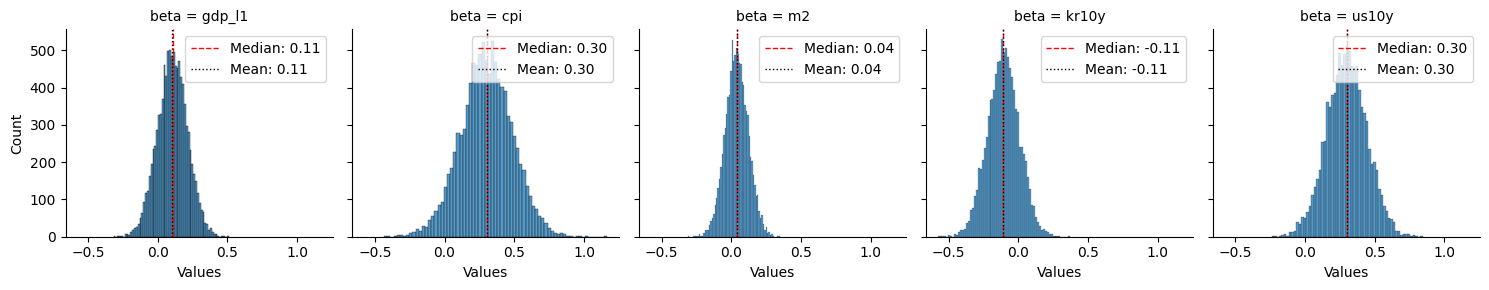

In [21]:
# beta 계수 히스토그램
plot_hist(res.beta, name='beta')

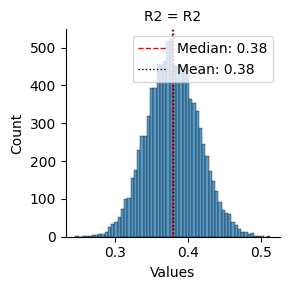

In [22]:
# R2 히스토그램
plot_hist(res.r2, name='R2')

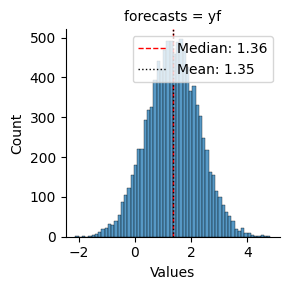

In [23]:
# 예측결과 히스토그램
plot_hist(res.yf, name='forecasts')

또는 res 인스턴스의 plot_hist 메서드를 이용해 바로 분포를 그릴 수 있다.

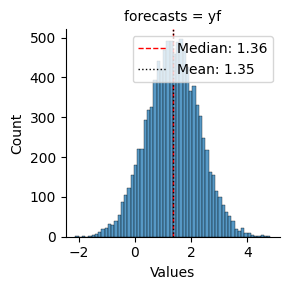

In [24]:
# 메서드 사용해서 히스토그램 그리기
res.plot_hist('yf')

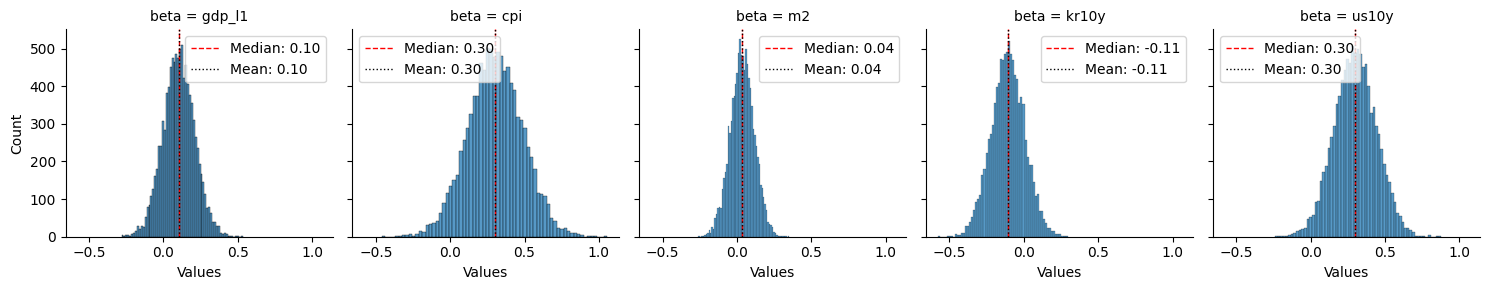

In [62]:
res.plot_hist('beta')

## BayesLinearRegression 클래스로 모형 설정하고 추정하기

`gibbs_lin` 함수를 사용하는 방법외에 `BayesLinearRegression` 클래스를 이용한 추정 기능도 제공한다.

모형 클래스 불러오기
- `bok_da` 라이브러리 `bayes` 패키안의 `linear_model` 서브패키지에서 `BayesLinearRegression` 클래스를 불러온다.

In [25]:
from bok_da.bayes.linear_model import BayesLinearRegression

모형 설정
- BLR 클래스를 이용해 model 객체를 생성한다. 여기서 model의 특성은 hyper에 의해 결정된다.

In [26]:
hyper = gen_hyper_para()
model = BayesLinearRegression(hyper)

모형 추정
- model 인스턴스의 fit 메서드를 이용해 추정할 수 있다.

In [27]:
res = model.fit(df)

결과 보기
- res 인스턴스에 대해서 위의 예와 동일하게 get_table, plot_hist 등의 메서드를 적용할 수 있다.

In [28]:
res.get_table('beta', quantile=[0.05, 0.95])

,Mean,Median,S.E.,0.05%,0.95%
gdp_l1,0.108846,0.108265,0.105200,-0.062204,0.282560
cpi,0.293077,0.292963,0.182078,-0.007750,0.591959
m2,0.043519,0.043848,0.080669,-0.088092,0.177939
kr10y,-0.089109,-0.090704,0.110831,-0.269853,0.093665
us10y,0.270057,0.271297,0.137224,0.042384,0.494956


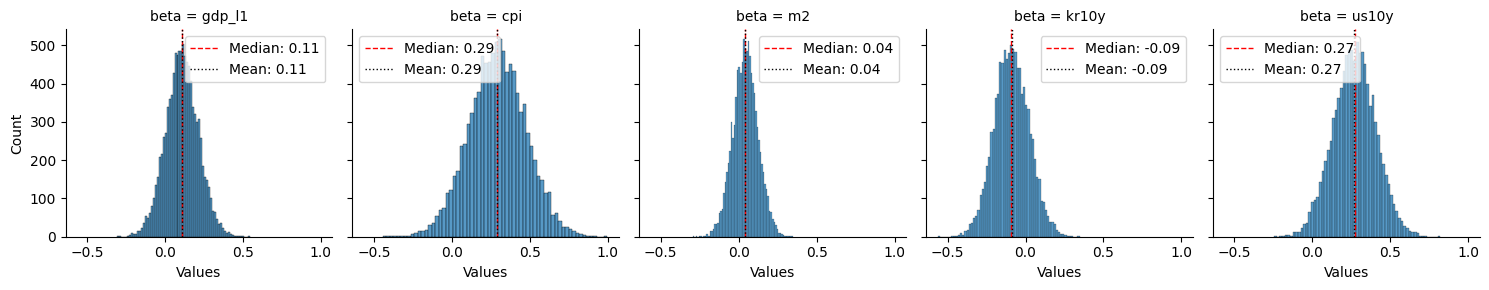

In [29]:
res.plot_hist('beta')

마지막 시점 예측: 예측분포와 log PPD(Posterior Predictive Density) 출력
- 예측대상 시점인 oos를 인자로 입력하고, model 인스턴스의 predict 메서드를 이용해서 예측할 수 있다.

In [30]:
oos = df.iloc[[-1]] # out-of-sample, data의 마지막행 전체열
res = model.predict(df, oos, print_info=True)

Coefficients: 
            Mean    Median      S.E.     0.05%     0.95%
gdp_l1  0.108586  0.106076  0.106283 -0.065293  0.283125
cpi     0.293050  0.293151  0.183045 -0.006062  0.592737
m2      0.043825  0.043953  0.081177 -0.088292  0.177937
kr10y  -0.089563 -0.090088  0.111506 -0.272644  0.094854
us10y   0.270857  0.271245  0.139037  0.042885  0.497952
R2: 
        Mean    Median      S.E.    0.05%     0.95%
R2  0.377903  0.376975  0.035209  0.32099  0.435989
Forecast: 
        Mean    Median      S.E.   0.05%     0.95%
yf  1.294275  1.299467  0.937832 -0.2525  2.832848
log PPL:  -1.114438221076
